In [1]:
import unibox

start comfyui:

```bash
COMFY_DIR = "/rmt/yada/apps/comfyui"
OUTPUT_DIR = "/lv0/comfy_outs"
START_PORT = 18188
CUDA_DEVICES = [0, 1, 2, 3, 4, 5, 6, 7]

cd $COMFY_DIR

for CUDA_DEVICE in $CUDA_DEVICES
    python main.py  --output-directory $OUTPUT_DIR --port $START_PORT --cuda-device $CUDA_DEVICE &


```

In [4]:
COMFY_DIR = "/rmt/yada/apps/comfyui"
OUTPUT_DIR = "/lv0/comfy_outs"
START_PORT = 18188
CUDA_DEVICES = [0, 1, 2, 3, 4, 5, 6, 7]


for device in CUDA_DEVICES:
    port = START_PORT + device
    command = f"python {COMFY_DIR}/main.py --port {port} --cuda-device {device} --output-dir {OUTPUT_DIR}"
    print(command)

python /rmt/yada/apps/comfyui/main.py --port 18188 --cuda-device 0 --output-dir /lv0/comfy_outs
python /rmt/yada/apps/comfyui/main.py --port 18189 --cuda-device 1 --output-dir /lv0/comfy_outs
python /rmt/yada/apps/comfyui/main.py --port 18190 --cuda-device 2 --output-dir /lv0/comfy_outs
python /rmt/yada/apps/comfyui/main.py --port 18191 --cuda-device 3 --output-dir /lv0/comfy_outs
python /rmt/yada/apps/comfyui/main.py --port 18192 --cuda-device 4 --output-dir /lv0/comfy_outs
python /rmt/yada/apps/comfyui/main.py --port 18193 --cuda-device 5 --output-dir /lv0/comfy_outs
python /rmt/yada/apps/comfyui/main.py --port 18194 --cuda-device 6 --output-dir /lv0/comfy_outs
python /rmt/yada/apps/comfyui/main.py --port 18195 --cuda-device 7 --output-dir /lv0/comfy_outs


## celery

In [15]:
import json
import msgpack
from celery import Celery


MQ_IP = "52.10.216.28"

# Initialize Celery client to connect to the broker
app = Celery('tasks', broker=f'pyamqp://runner:UjLyQtRMWTG68aAKecq4Hn@{MQ_IP}//', backend='rpc://')

# Import the task module explicitly to ensure the task is registered
import comfyui_router.tasks
from comfyui_router.tasks import process_request

# JSON string to be sent
json_string = '{"6": {"inputs": {"text": "1girl, very long hair", "clip": ["101", 1]}, "class_type": "CLIPTextEncode", "_meta": {"title": "POSITIVE"}}, "7": {"inputs": {"text": "lowres, worst quality, displeasing, bad quality, bad anatomy, text, error, extra digit, cropped, average quality", "clip": ["101", 1]}, "class_type": "CLIPTextEncode", "_meta": {"title": "NEGATIVE"}}, "101": {"inputs": {"ckpt_name": "bxl-v5c-cont53/checkpoint-e1_s25000.safetensors"}, "class_type": "CheckpointLoaderSimple", "_meta": {"title": "Load Checkpoint"}}, "103": {"inputs": {"filename_prefix": "ComfyUI", "images": ["34:4", 0]}, "class_type": "SaveImage", "_meta": {"title": "Save Image"}}, "34:0": {"inputs": {"width": 896, "height": 1152, "batch_size": 4}, "class_type": "EmptyLatentImage", "_meta": {"title": "Empty Latent Image"}}, "34:1": {"inputs": {"multiplier": 0.75, "model": ["101", 0]}, "class_type": "RescaleCFG", "_meta": {"title": "RescaleCFG"}}, "34:2": {"inputs": {"sampling": "v_prediction", "zsnr": true, "model": ["34:1", 0]}, "class_type": "ModelSamplingDiscrete", "_meta": {"title": "ModelSamplingDiscrete"}}, "34:3": {"inputs": {"seed": 432737405573798, "steps": 28, "cfg": 5.5, "sampler_name": "euler", "scheduler": "normal", "denoise": 1, "model": ["34:2", 0], "positive": ["6", 0], "negative": ["7", 0], "latent_image": ["34:0", 0]}, "class_type": "KSampler", "_meta": {"title": "KSampler"}}, "34:4": {"inputs": {"samples": ["34:3", 0], "vae": ["101", 2]}, "class_type": "VAEDecode", "_meta": {"title": "VAE Decode"}}}'
json_data = json.loads(json_string)

# Unique key for the request
unique_key = "debug_request_001"

# Send the request to the Celery worker
result = app.send_task('comfyui_router.tasks.process_request', args=[unique_key, json_data])

# Wait for the result (blocking)
packed_response = result.get(timeout=40)  # You can adjust the timeout as needed

# Decode the MessagePack response
unique_key, raw_response = msgpack.unpackb(packed_response, raw=False)

In [14]:
from PIL import Image
import io

def extract_images(raw_response):
    extracted_images = {}
    
    for node_id, result_data_list in raw_response.items():
        images = []
        for result_data in result_data_list:
            if isinstance(result_data, bytes):
                # Process binary data (e.g., image)
                try:
                    img = Image.open(io.BytesIO(result_data))
                    images.append(img)
                except Exception as e:
                    print(f"Error decoding image for node {node_id}: {e}")
            else:
                # Handle other data types if necessary, here we are only interested in images
                print(f"Non-image data encountered in node {node_id}: {result_data}")
        
        if images:
            extracted_images[node_id] = images
    
    return extracted_images


node_imgs = extract_images(raw_response)

In [11]:
node_imgs

{'103': [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=896x1152>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=896x1152>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=896x1152>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=896x1152>]}

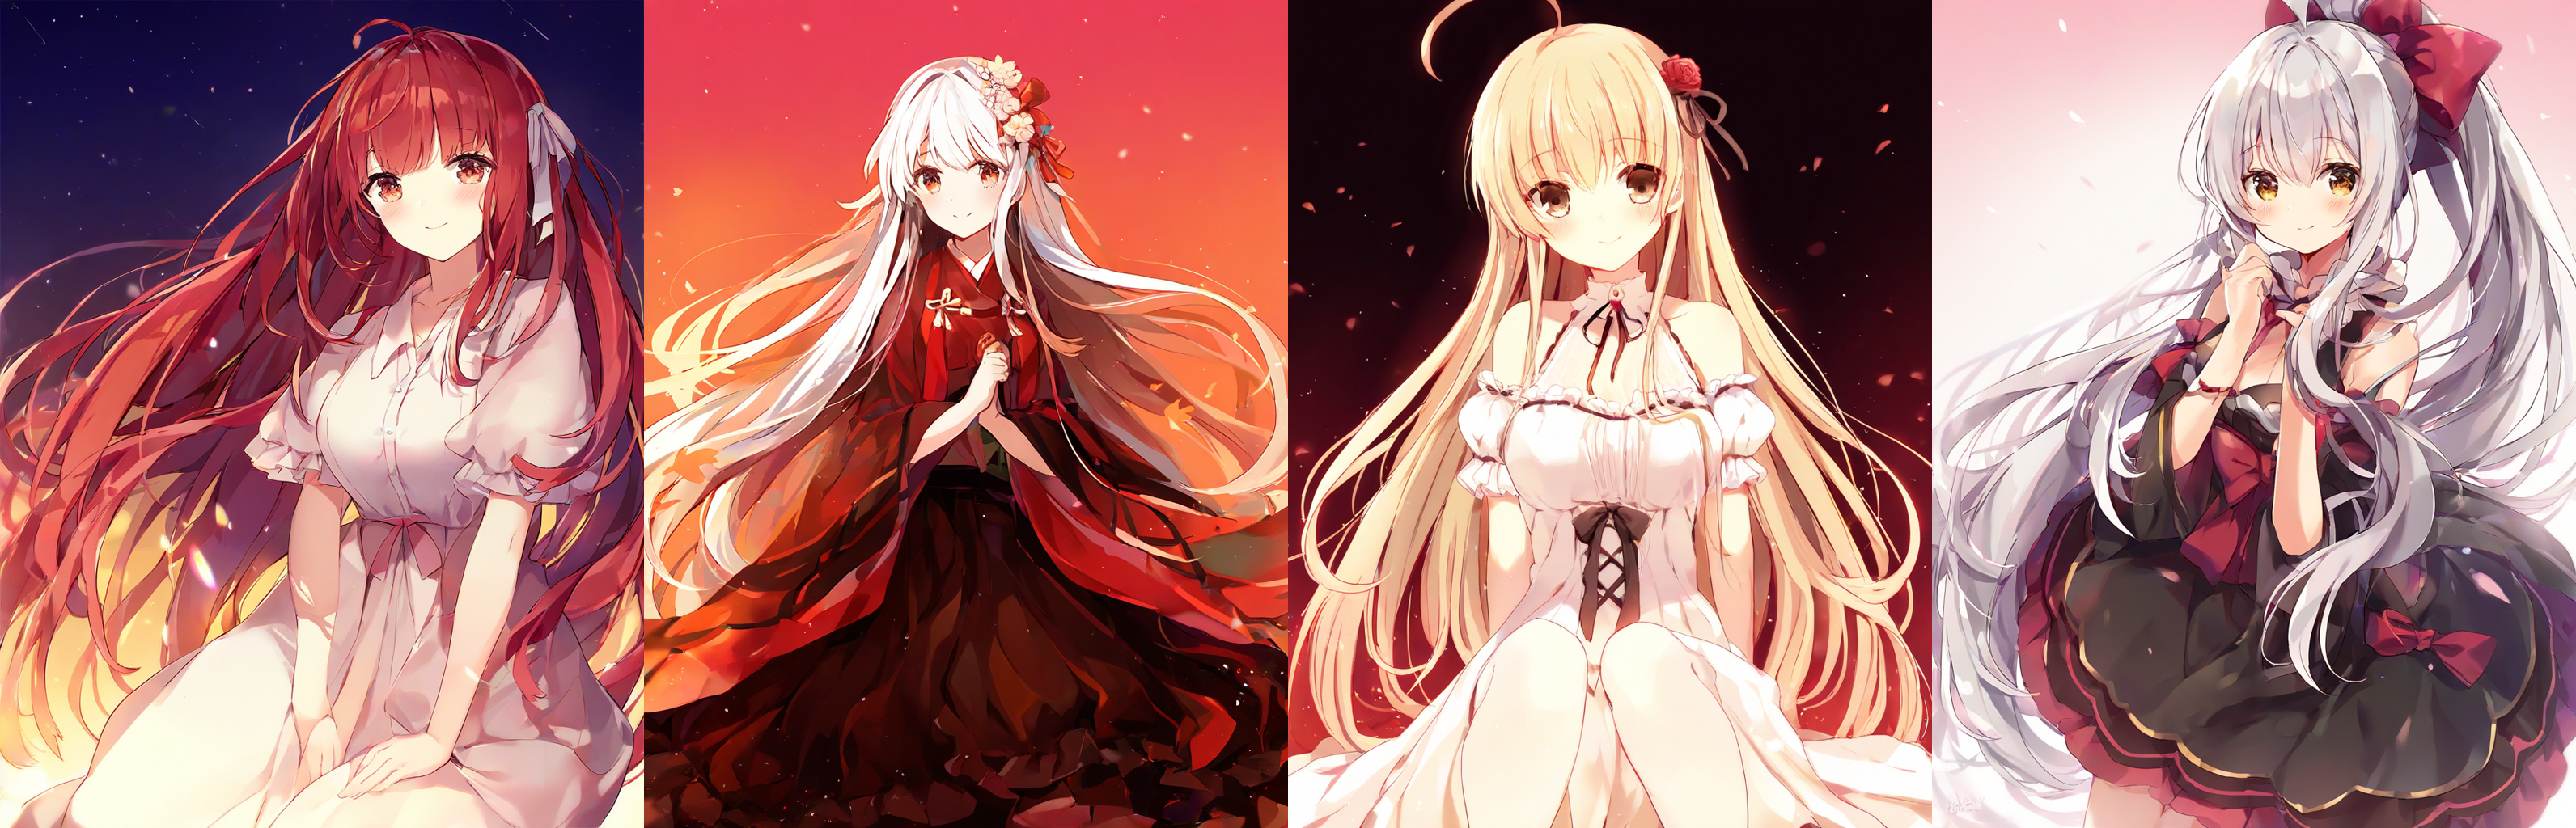

In [13]:
from dataproc4.utils.image_utils import concatenate_images_horizontally

concatenate_images_horizontally(node_imgs['103'])

In [8]:
output = result.get(timeout=30)  # You can adjust the timeout as needed

# Print the output for debugging
print(f"Unique Key: {output[0]}")
print(f"Result: {output[1]}")

TimeoutError: The operation timed out.